## Import Libraries

In [5]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn.cluster import DBSCAN


%matplotlib inline

## Load the Data

In [6]:
df = pd.read_csv("../data/cleaned_df_ehsan.csv")

In [7]:
df.shape

(1485, 12)

In [8]:
df.tail(2)

,Unnamed: 0,Case Number,Project Names,Amount,Date,Beneficiaries,Beneficiary type,Number of donations,Partner,Location,Details URL,Hijri_Month
1483,1483,P47317,دعم الأسر المنتجة,200000,2024-01-25,10,المواطنون,18792,جمعية التنمية الأهلية بالشقيق,الشقيق,https://ehsan.sa/projects/0/46318?amount=null,رجب
1484,1484,P47306,دعم الأسر المحتاجة,250000,2024-01-25,250,المواطنون,16538,جمعية البر والخدمات الاجتماعية بمركز ترج,بيشة,https://ehsan.sa/projects/0/46307?amount=null,رجب


In [9]:
df['Location'].value_counts()

Location
الرياض             201
مكة المكرمة        159
جدة                 57
المدينة المنورة     52
جازان               39
                  ... 
بني سار              1
الأضارع              1
صفوى                 1
الخفجي               1
الجرين               1
Name: count, Length: 284, dtype: int64

In [10]:
# Create a mapping of locations to their encoded values based on frequency
location_counts = df['Location'].value_counts()
location_mapping = {location: i for i, location in enumerate(location_counts.index)}

# Create a custom encoding function using the mapping
def encode_location(location):
    return location_mapping.get(location)

# Apply the custom encoding function to the 'Location' column
df['Location_encoded'] = df['Location'].apply(encode_location)

# Now, df['Location_encoded'] contains encoded values
# that reflect the frequency of locations in the original data

In [11]:
df['Partner'].value_counts()

Partner
جمعية رحماء الصحية                                      82
جمعية الإحسان الطبية الخيرية                            23
مجمع الملك فهد لطباعة المصحف الشريف بالمدينة المنورة    20
جمعية الكوثر الصحية بعسير                               12
جمعية إكرام عابري السبيل                                12
                                                        ..
جمعية إحسان لحفظ النعمة بمحافظة صبيا                     1
الجمعية الخيرية لتحفيظ القرآن الكريم بمحافظة السليل      1
جمعية الدعوة والإرشاد وتوعية الجاليات بالقرين            1
جمعية تحبير لتحفيظ القرآن بمركز الشعبة                   1
جمعية البر الاهلية بباشوت                                1
Name: count, Length: 742, dtype: int64

In [12]:
# Create a mapping of partners to their encoded values based on frequency
partner_counts = df['Partner'].value_counts()
partner_mapping = {partner: i for i, partner in enumerate(partner_counts.index)}

# Create a custom encoding function using the mapping
def encode_partner(partner):
    return partner_mapping.get(partner)

# Apply the custom encoding function to the 'Partner' column
df['Partner_encoded'] = df['Partner'].apply(encode_partner)



In [13]:
#!pip install hijri-converter

In [14]:
from hijri_converter import convert

In [15]:
def get_hijri_month_num(date_str):
    # Convert the date string to a datetime object
    date_obj = pd.to_datetime(date_str, format='%Y-%m-%d', errors='coerce')  # Adjust format if needed

    # Check if the conversion was successful
    if pd.notna(date_obj):
        hijri_date = convert.Gregorian(date_obj.year, date_obj.month, date_obj.day).to_hijri()
        hijri_month = hijri_date.month  # Get the Hijri month number
        return hijri_month  # Return the number directly
    else:
        return None  # Handle invalid date strings

# Apply the function to the 'Date' column and create a new 'Hijri_Month_Num' column
df['Hijri_Month'] = df['Date'].apply(get_hijri_month_num)

#### 2. Feature Engineering

In [16]:
df

,Unnamed: 0,Case Number,Project Names,Amount,Date,Beneficiaries,Beneficiary type,Number of donations,Partner,Location,Details URL,Hijri_Month,Location_encoded,Partner_encoded
0,0,P49631,وجبات الإفطار في ساحات الحرم المكي,300000,2025-03-07,20000,المواطنون والمقيمون بالمملكة,16226,جمعية البر الخيرية بالأبواء,مكة المكرمة,https://ehsan.sa/projects/0/48632?amount=null,9,1,256
1,1,P49553,وجبات السحور للصائمين,280000,2025-03-07,20000,المواطنون والمقيمون بالمملكة,24403,جمعية البر الخيرية بالنويعمة,وادى الدواسر,https://ehsan.sa/projects/0/48554?amount=null,9,66,93
2,2,P49625,وجبات الإفطار لضيوف الرحمن,300000,2025-03-07,30000,المواطنون والمقيمون بالمملكة,11930,جمعية البر الخيرية بالحوية,السيل الكبير,https://ehsan.sa/projects/0/48626?amount=null,9,134,140
3,3,P49618,ترميم مساكن المتعففين,300000,2025-03-07,11,المواطنون,9378,الجمعية الخيرية ببللحمر,باللحمر,https://ehsan.sa/projects/0/48619?amount=null,9,137,454
4,4,P49626,عملية في العمود الفقري لمريضة متعففة,24000,2025-03-07,1,المقيمون بالمملكة,145,جمعية رحماء الصحية,الرياض,https://ehsan.sa/projects/0/48627?amount=null,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,1480,P47450,توفير البطانيات للأسر المحتاجة,103680,2024-01-25,432,المواطنون,7685,جمعية الجرين الأهلية,الجرين,https://ehsan.sa/projects/0/46451?amount=null,7,283,433
1481,1481,P47439,غرس الأشجار لمكافحة التصحر,80000,2024-01-25,1000,المقيمون بالمملكة,8673,أجيالنا التطوعية,النماص,https://ehsan.sa/projects/0/46440?amount=null,7,40,432
1482,1482,P47441,تأثيث منازل المحتاجين,75000,2024-01-25,3,المواطنون,4777,جمعية البر الاهلية بباشوت,باشوت,https://ehsan.sa/projects/0/46442?amount=null,7,172,741
1483,1483,P47317,دعم الأسر المنتجة,200000,2024-01-25,10,المواطنون,18792,جمعية التنمية الأهلية بالشقيق,الشقيق,https://ehsan.sa/projects/0/46318?amount=null,7,149,170




#### 3. Feature selection

In [17]:
df_1 = df[['Amount','Location_encoded','Hijri_Month','Partner_encoded']]

In [18]:
df_2 = df[['Number of donations','Beneficiaries','Location_encoded','Hijri_Month']]

In [19]:
df_1.head(2)

,Amount,Location_encoded,Hijri_Month,Partner_encoded
0,300000,1,9,256
1,280000,66,9,93


In [20]:
df_2.head(2)

,Number of donations,Beneficiaries,Location_encoded,Hijri_Month
0,16226,20000,1,9
1,24403,20000,66,9


#### 4. Prepare train and test data

In [21]:
# Prepare data mor model_1
X1 = df_1


# sacle the data
scaler = StandardScaler()
X_scaled_1 = scaler.fit_transform(X1)

In [22]:
# Prepare data for model_2
X2 = df_2


# sacle the data
scaler = StandardScaler()
X_scaled_2 = scaler.fit_transform(X2)

In [23]:
X1.shape


(1485, 4)

In [24]:
X2.shape

(1485, 4)

## Evaluating the Model

In [25]:
from sklearn.metrics import silhouette_samples, silhouette_score

##DBSCAN models

In [26]:
# 2. Create and fit the DBSCAN model
X4 = df_2
X_scaled_4 = scaler.fit_transform(X4)

#model_4 = DBSCAN(eps=0.9, min_samples=3)
model_4 = DBSCAN(eps=0.9, min_samples=6)  # Adjust eps and min_samples as needed
#y_pred_4 = model_4.fit_predict(X_scaled_2)
y_pred_4 = model_4.fit_predict(X_scaled_4)
df_1['dbscan_cluster'] = y_pred_4

In [27]:
cluster_num = len(set(y_pred_4))
print(f'number of cluster are for model_4: {cluster_num}')

number of cluster are for model_4: 5


In [28]:
X4['y_pred_4'] = y_pred_4
X4['y_pred_4'].value_counts()

y_pred_4
 0    1382
-1      56
 2      26
 1      15
 3       6
Name: count, dtype: int64

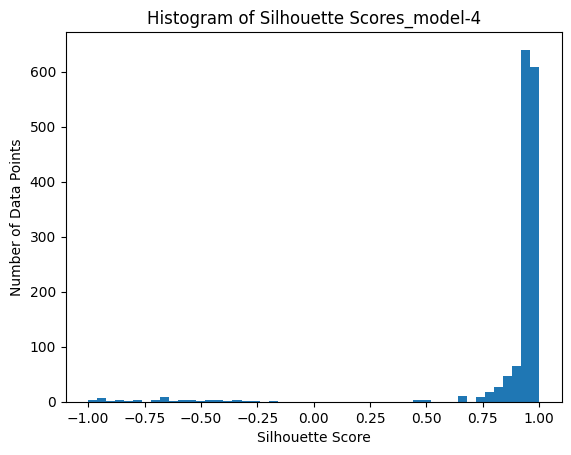

Silhouette average score: 0.8808697312186221


In [29]:
#df_2 = df[['Number of donations','Beneficiaries','Location_encoded','Hijri_Month']]

# Calculate Silhouette scores for each data point
silhouette_scores = silhouette_samples(X4, y_pred_4)

# Calculate Silhouette average score
silhouette_avg = silhouette_score(X4, y_pred_4)

# Plot Silhouette scores
plt.hist(silhouette_scores, bins=50, range=(-1, 1))
plt.title('Histogram of Silhouette Scores_model-4')
plt.xlabel('Silhouette Score')
plt.ylabel('Number of Data Points')
plt.show()

print(f'Silhouette average score: {silhouette_avg}')




### model_4 visualization


In [30]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Number of donations  1485 non-null   int64
 1   Beneficiaries        1485 non-null   int64
 2   Location_encoded     1485 non-null   int64
 3   Hijri_Month          1485 non-null   int64
 4   y_pred_4             1485 non-null   int64
dtypes: int64(5)
memory usage: 58.1 KB


<Axes: xlabel='Number of donations', ylabel='Location_encoded'>

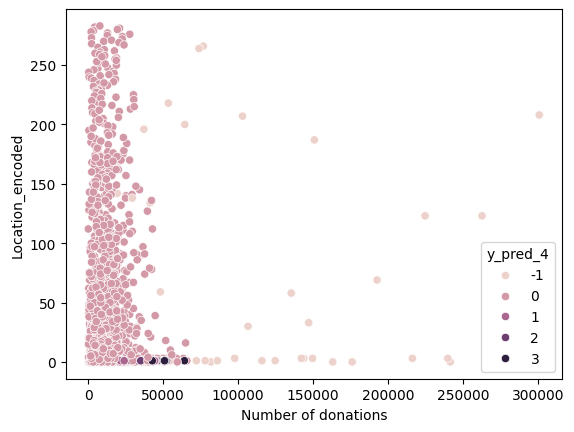

In [31]:
#df_2 = df[['Number of donations','Beneficiaries','Location_encoded','Hijri_Month']]
sns.scatterplot(data = X4 , x = 'Number of donations', y = 'Location_encoded', hue = 'y_pred_4')

<Axes: xlabel='Location_encoded', ylabel='Hijri_Month'>

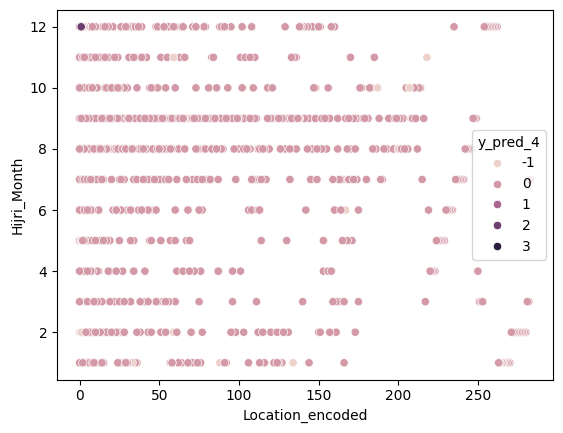

In [32]:
#df_2 = df[['Number of donations','Beneficiaries','Location_encoded','Hijri_Month']]
sns.scatterplot(data = X4 , x = 'Location_encoded', y = 'Hijri_Month', hue = 'y_pred_4')



<Axes: xlabel='Number of donations', ylabel='Hijri_Month'>

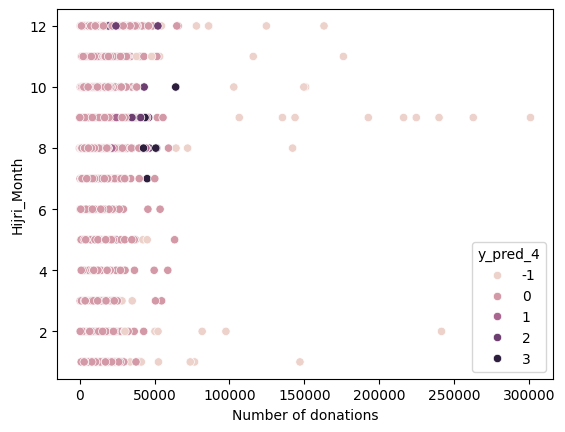

In [33]:
#df_2 = df[['Number of donations','Beneficiaries','Location_encoded','Hijri_Month']]
sns.scatterplot(data = X4, x = 'Number of donations', y = 'Hijri_Month', hue = 'y_pred_4')

<Axes: xlabel='Beneficiaries', ylabel='Location_encoded'>

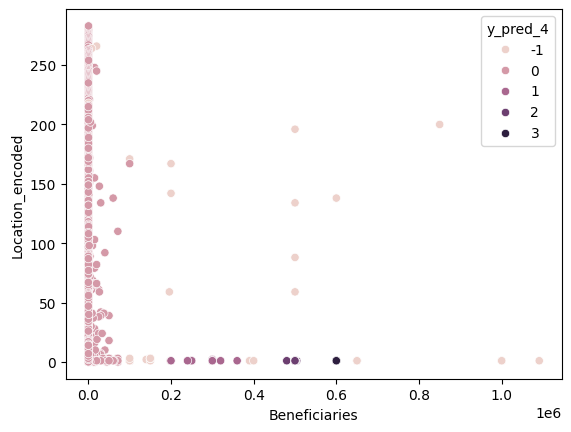

In [34]:
#df_2 = df[['Number of donations','Beneficiaries','Location_encoded','Hijri_Month']]
sns.scatterplot(data = X4 , x = 'Beneficiaries', y = 'Location_encoded', hue = 'y_pred_4')

In [35]:
#df_2 = df[['Number of donations','Beneficiaries','Location_encoded','Hijri_Month']]

import plotly
import plotly.express as px

fig = px.scatter_3d(X4, x='Number of donations', y='Location_encoded', z='Hijri_Month',
              color='y_pred_4')
fig.show()

In [36]:
#df_2 = df[['Number of donations','Beneficiaries','Location_encoded','Hijri_Month']]

fig = px.scatter_3d(X4, x='Beneficiaries', y='Location_encoded', z='Hijri_Month',
              color='y_pred_4')
fig.show()


''' cluster _0 :     مجموعة مشاريع في كل المناطق الي تغطيها احسان بكل اشهر السنة وعدد المستفيدين فيها 200 الف واقل '''

' cluster _0 :     مجموعة مشاريع في كل المناطق الي تغطيها احسان بكل اشهر السنة وعدد المستفيدين فيها 200 الف واقل '

In [37]:
#df_2 = df[['Number of donations','Beneficiaries','Location_encoded','Hijri_Month']]

import plotly
import plotly.express as px

fig = px.scatter_3d(X4, x='Number of donations', y='Location_encoded', z='Beneficiaries',
              color='y_pred_4')
fig.show()

In [38]:
import joblib
joblib.dump(model_4.components_, 'dbscan_core_points.joblib')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [39]:
import joblib

dbscan_data = {
    "components": model_4.components_,
    "labels": model_4.labels_[model_4.core_sample_indices_],
    "eps": model_4.eps
}
joblib.dump(dbscan_data, 'dbscan_core_points.joblib')


['dbscan_core_points.joblib']

curl -X POST "http://localhost:8000/predict" \
-H "Content-Type: application/json" \
-d '{
"Year": 2020,
"Engine_Size": 2.5,
"Mileage": 15000,
"Type": "Accent",
"Make": "Hyundai",
"Options": "Full"
}'


curl -x post "http://localhost:8000/predict" \ 
-H "Content-Type: application/json" \
-d '{ 
    Number of donations: 200
    'Beneficiaries':200
    'Location_encoded':0
    'Hijri_Month':9
    }

curl -X POST "http://localhost:8000/predict" -H "Content-Type: application/json" -d "{ \"Number of donations\": 200, \"Beneficiaries\": 200, \"Location_encoded\": 0, \"Hijri_Month\": 9 }"


$headers = @{ "Content-Type" = "application/json" }
$body = @{
    "Number of donations" = 200
    "Beneficiaries" = 200
    "Location_encoded" = 0
    "Hijri_Month" = 9
} | ConvertTo-Json

Invoke-RestMethod -Uri "http://localhost:8000/" -Method Post -Headers $headers -Body $body


curl -x post "http://localhost:8000/predict" /
-H "Content-Type: application/json" /
-d '{ 
    Number of donations: 200
    'Beneficiaries':200
    'Location_encoded':0
    'Hijri_Month':9
    }

curl -X POST -H "Content-Type: application/json" -d "{\"Number of donations\": 200, \"Beneficiaries\": 200,\"Location_encoded\":0, \"Hijri_Month\": 9 }" http://localhost:8000/predict